In [3]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from random import randint
from typing import Optional
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchmetrics import JaccardIndex

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATADIR = 'DATASET/'

In [4]:
def image_rz(img):
  height = img.shape[0]
  width = img.shape[1]
  problem = abs(height - width)
  sz = [int(problem / 2), problem - int(problem / 2), 0]
  if width >= height:
    img = cv2.copyMakeBorder(img, sz[0], sz[1], sz[2],
                            sz[2], cv2.BORDER_CONSTANT)
  else:
    img = cv2.copyMakeBorder(img, sz[2], sz[2], sz[0],
                            sz[1], cv2.BORDER_CONSTANT)
  img = cv2.resize(img, (256, 256))
  return img

In [5]:
images_path = DATADIR + 'images/'
masks_path = DATADIR + 'masks/'

file_names = os.listdir(images_path)
images = []
for fname in sorted(file_names):
  image_path = os.path.join(images_path, fname)
  image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
  image = image_rz(image)
  images += [image]

file_names = os.listdir(masks_path)
masks = []
for fname in sorted(file_names):
  mask_path = os.path.join(masks_path, fname)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = image_rz(mask)
  masks += [mask]

In [6]:
train_im, test_im, train_mk, test_mk = train_test_split(images, masks, test_size = 0.20)

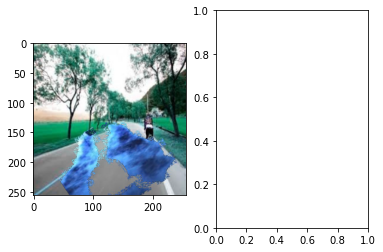

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test_im[0])
# ax2.imshow(train_mk[3300])

In [8]:
class SmokeDataset(Dataset):
    
    def __init__(self, images, masks, transforms):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        image = self.transforms(image)
        
        return image, mask

In [9]:
train_batch_size=4
test_batch_size=4
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.4992, 0.5037, 0.5032), (0.2844, 0.2635, 0.2712))])

train_set = SmokeDataset(train_im, train_mk, transform)
test_set = SmokeDataset(test_im, test_mk, transform)

train_loader = DataLoader(train_set, train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, test_batch_size)

In [10]:
# mean = torch.tensor([0., 0., 0.])
# std = torch.tensor([0., 0., 0.])
# for data in train_loader:
#   img, mask = data
#   mean += img.mean([0, 2, 3])
#   std += img.std([0, 2, 3]) 
# mean /= len(train_loader)
# std /= len(train_loader)
# print(mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


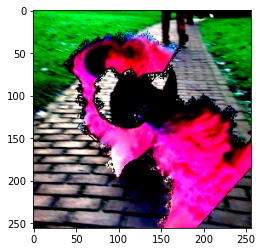

In [11]:
fig, ax = plt.subplots(1, 1)
for data in train_loader:
  img, mask = data
  image = img[0].permute(1, 2, 0).numpy()
  ax.imshow(image)
  break

In [12]:
model = torch.hub.load(
        'mateuszbuda/brain-segmentation-pytorch',
        'unet',
        in_channels=3,
        out_channels=1,
        init_features=32,
        pretrained=True,
    )
model.to(device)
for name, param in model.named_parameters():
  if 'encoder1' in name or 'encoder2' in name:
    param.requires_grad = False
  if 'decoder1' in name or 'decoder2' in name:
    param.requires_grad = False
  if 'upconv1' in name or 'upconv2' in name:
    param.requires_grad = False

Using cache found in C:\Users\Danko/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [13]:
def show_loss(train_loss):
    fig=plt.figure(figsize=(10, 7))
    plt.plot(np.arange(1, len(train_loss)+1), train_loss, label="Train loss")
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.title("Loss Plots")
    plt.legend(loc='upper right')
    plt.show()

In [14]:
def iou(realMask, resultMask):
  acc = 0.0
  for mask_orig, mask in zip(realMask, resultMask):
    m = JaccardIndex(num_classes=2)
    m = m.to(device)
    acc += m(mask_orig, mask)
  return acc

In [15]:
def train(model, loss_fn, train_loader, test_loader, learning_rate=1e-4, num_epoch=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epoch):
        model.train()
        epoch_loss = 0
        if epoch == 10:
            learning_rate /= 10
        if epoch == 15:
            learning_rate /= 2
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            images, masks_orig = data
            images = images.to(device)
            masks_orig = masks_orig.to(device)
            masks = model(images)
            masks = masks.squeeze(1)
            masks_orig = masks_orig.float()/255.0
            loss = loss_fn(masks, masks_orig)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss = epoch_loss/(i+1)
        train_loss.append(epoch_loss) 
        print("Epoch: {} Train Loss: {:.4}".format(epoch, epoch_loss))

        model.eval()
        acc = 0
        for i, data in enumerate(test_loader):
            images, masks_orig = data
            images = images.to(device)
            masks_orig =  masks_orig.to(device) > 128
            masks = model(images)
            masks = masks.squeeze(1)
            masks = (masks.round()).int()
            acc_batch = iou(masks_orig, masks)
            acc += acc_batch/len(images)
            print(acc_batch/len(images))
            
        acc = acc/(i+1)
        test_loss.append(acc.to('cpu'))
        print("Epoch: {} Test Acc: {:.4}\n".format(epoch, acc))
        torch.save(model.state_dict(), "model_weights-" + str(epoch + 1) + ".pth") \
        
    show_loss(train_loss)
    show_loss(test_loss)
    return acc

Epoch: 0 Train Loss: 0.7958
tensor(0.6673, device='cuda:0')
tensor(0.8760, device='cuda:0')
tensor(0.8220, device='cuda:0')
tensor(0.6574, device='cuda:0')
tensor(0.7363, device='cuda:0')
tensor(0.8686, device='cuda:0')
tensor(0.6983, device='cuda:0')
tensor(0.7593, device='cuda:0')
tensor(0.7777, device='cuda:0')
tensor(0.8623, device='cuda:0')
tensor(0.8259, device='cuda:0')
tensor(0.8276, device='cuda:0')
tensor(0.7731, device='cuda:0')
tensor(0.8555, device='cuda:0')
tensor(0.9111, device='cuda:0')
tensor(0.6174, device='cuda:0')
tensor(0.8063, device='cuda:0')
tensor(0.7389, device='cuda:0')
tensor(0.6952, device='cuda:0')
tensor(0.8934, device='cuda:0')
tensor(0.7683, device='cuda:0')
tensor(0.7086, device='cuda:0')
tensor(0.8128, device='cuda:0')
tensor(0.8192, device='cuda:0')
tensor(0.8403, device='cuda:0')
tensor(0.7686, device='cuda:0')
tensor(0.6293, device='cuda:0')
tensor(0.8459, device='cuda:0')
tensor(0.8126, device='cuda:0')
tensor(0.7840, device='cuda:0')
tensor(0.812

tensor(0.8116, device='cuda:0')
tensor(0.9032, device='cuda:0')
tensor(0.8639, device='cuda:0')
tensor(0.8996, device='cuda:0')
tensor(0.8366, device='cuda:0')
tensor(0.9000, device='cuda:0')
tensor(0.8387, device='cuda:0')
tensor(0.8778, device='cuda:0')
tensor(0.9043, device='cuda:0')
tensor(0.9033, device='cuda:0')
tensor(0.8556, device='cuda:0')
tensor(0.8116, device='cuda:0')
tensor(0.7415, device='cuda:0')
tensor(0.8727, device='cuda:0')
tensor(0.8730, device='cuda:0')
tensor(0.8167, device='cuda:0')
tensor(0.8880, device='cuda:0')
tensor(0.8980, device='cuda:0')
tensor(0.9201, device='cuda:0')
tensor(0.8005, device='cuda:0')
tensor(0.8589, device='cuda:0')
tensor(0.8282, device='cuda:0')
tensor(0.8088, device='cuda:0')
tensor(0.8824, device='cuda:0')
tensor(0.9272, device='cuda:0')
tensor(0.8084, device='cuda:0')
tensor(0.8717, device='cuda:0')
tensor(0.8333, device='cuda:0')
tensor(0.8812, device='cuda:0')
tensor(0.9018, device='cuda:0')
tensor(0.9273, device='cuda:0')
tensor(0

tensor(0.9343, device='cuda:0')
tensor(0.9143, device='cuda:0')
tensor(0.9319, device='cuda:0')
tensor(0.7558, device='cuda:0')
tensor(0.8622, device='cuda:0')
tensor(0.8266, device='cuda:0')
tensor(0.9184, device='cuda:0')
tensor(0.9371, device='cuda:0')
tensor(0.8194, device='cuda:0')
tensor(0.7380, device='cuda:0')
tensor(0.9149, device='cuda:0')
tensor(0.9236, device='cuda:0')
tensor(0.9291, device='cuda:0')
tensor(0.9135, device='cuda:0')
tensor(0.7546, device='cuda:0')
tensor(0.9233, device='cuda:0')
tensor(0.9193, device='cuda:0')
tensor(0.9252, device='cuda:0')
tensor(0.9115, device='cuda:0')
tensor(0.9191, device='cuda:0')
tensor(0.9493, device='cuda:0')
tensor(0.8991, device='cuda:0')
tensor(0.8355, device='cuda:0')
tensor(0.9450, device='cuda:0')
tensor(0.8429, device='cuda:0')
tensor(0.8177, device='cuda:0')
tensor(0.9516, device='cuda:0')
tensor(0.8100, device='cuda:0')
tensor(0.8796, device='cuda:0')
tensor(0.9126, device='cuda:0')
tensor(0.9356, device='cuda:0')
tensor(0

tensor(0.8246, device='cuda:0')
tensor(0.8568, device='cuda:0')
tensor(0.8865, device='cuda:0')
tensor(0.9174, device='cuda:0')
tensor(0.9209, device='cuda:0')
tensor(0.9395, device='cuda:0')
tensor(0.7800, device='cuda:0')
tensor(0.8869, device='cuda:0')
tensor(0.8502, device='cuda:0')
tensor(0.8627, device='cuda:0')
tensor(0.9031, device='cuda:0')
tensor(0.9554, device='cuda:0')
tensor(0.9004, device='cuda:0')
tensor(0.9452, device='cuda:0')
tensor(0.8607, device='cuda:0')
tensor(0.8471, device='cuda:0')
tensor(0.9029, device='cuda:0')
tensor(0.9277, device='cuda:0')
tensor(0.8301, device='cuda:0')
tensor(0.9479, device='cuda:0')
tensor(0.9265, device='cuda:0')
tensor(0.9407, device='cuda:0')
tensor(0.9332, device='cuda:0')
tensor(0.9209, device='cuda:0')
tensor(0.9308, device='cuda:0')
tensor(0.9193, device='cuda:0')
tensor(0.8021, device='cuda:0')
tensor(0.9163, device='cuda:0')
tensor(0.8194, device='cuda:0')
tensor(0.9165, device='cuda:0')
tensor(0.9329, device='cuda:0')
tensor(0

tensor(0.9255, device='cuda:0')
tensor(0.7291, device='cuda:0')
tensor(0.9391, device='cuda:0')
tensor(0.9439, device='cuda:0')
tensor(0.9350, device='cuda:0')
tensor(0.9230, device='cuda:0')
tensor(0.9396, device='cuda:0')
tensor(0.9572, device='cuda:0')
tensor(0.9143, device='cuda:0')
tensor(0.8876, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.8021, device='cuda:0')
tensor(0.8351, device='cuda:0')
tensor(0.9597, device='cuda:0')
tensor(0.8267, device='cuda:0')
tensor(0.9291, device='cuda:0')
tensor(0.9216, device='cuda:0')
tensor(0.9487, device='cuda:0')
tensor(0.9515, device='cuda:0')
tensor(0.8611, device='cuda:0')
tensor(0.9348, device='cuda:0')
tensor(0.8524, device='cuda:0')
tensor(0.9476, device='cuda:0')
tensor(0.8824, device='cuda:0')
tensor(0.9488, device='cuda:0')
tensor(0.9021, device='cuda:0')
tensor(0.8383, device='cuda:0')
tensor(0.9527, device='cuda:0')
tensor(0.9183, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9106, device='cuda:0')
tensor(0

tensor(0.8887, device='cuda:0')
tensor(0.9183, device='cuda:0')
tensor(0.9440, device='cuda:0')
tensor(0.9608, device='cuda:0')
tensor(0.8777, device='cuda:0')
tensor(0.9530, device='cuda:0')
tensor(0.9398, device='cuda:0')
tensor(0.9508, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9485, device='cuda:0')
tensor(0.9725, device='cuda:0')
tensor(0.8320, device='cuda:0')
tensor(0.9256, device='cuda:0')
tensor(0.9393, device='cuda:0')
tensor(0.9354, device='cuda:0')
tensor(0.9491, device='cuda:0')
tensor(0.8885, device='cuda:0')
tensor(0.9505, device='cuda:0')
tensor(0.9587, device='cuda:0')
tensor(0.8390, device='cuda:0')
tensor(0.9424, device='cuda:0')
tensor(0.8589, device='cuda:0')
tensor(0.9485, device='cuda:0')
tensor(0.9338, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9247, device='cuda:0')
tensor(0.9586, device='cuda:0')
tensor(0.9302, device='cuda:0')
tensor(0.9500, device='cuda:0')
tensor(0.9575, device='cuda:0')
tensor(0

tensor(0.9302, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(0.9535, device='cuda:0')
tensor(0.9530, device='cuda:0')
tensor(0.8422, device='cuda:0')
tensor(0.9188, device='cuda:0')
tensor(0.9113, device='cuda:0')
tensor(0.9620, device='cuda:0')
tensor(0.8786, device='cuda:0')
tensor(0.9448, device='cuda:0')
tensor(0.9087, device='cuda:0')
tensor(0.8413, device='cuda:0')
tensor(0.9615, device='cuda:0')
tensor(0.9365, device='cuda:0')
tensor(0.9540, device='cuda:0')
tensor(0.9223, device='cuda:0')
tensor(0.9559, device='cuda:0')
tensor(0.8493, device='cuda:0')
tensor(0.9613, device='cuda:0')
tensor(0.9640, device='cuda:0')
tensor(0.9428, device='cuda:0')
tensor(0.9561, device='cuda:0')
tensor(0.8500, device='cuda:0')
tensor(0.9217, device='cuda:0')
tensor(0.9694, device='cuda:0')
tensor(0.8625, device='cuda:0')
tensor(0.9313, device='cuda:0')
tensor(0.9463, device='cuda:0')
tensor(0.9679, device='cuda:0')
tensor(0.9344, device='cuda:0')
tensor(0.9552, device='cuda:0')
tensor(0

tensor(0.9517, device='cuda:0')
tensor(0.9521, device='cuda:0')
tensor(0.9636, device='cuda:0')
tensor(0.9149, device='cuda:0')
tensor(0.9506, device='cuda:0')
tensor(0.9684, device='cuda:0')
tensor(0.9502, device='cuda:0')
tensor(0.9617, device='cuda:0')
tensor(0.8630, device='cuda:0')
tensor(0.9543, device='cuda:0')
tensor(0.9363, device='cuda:0')
tensor(0.9597, device='cuda:0')
tensor(0.9411, device='cuda:0')
tensor(0.9593, device='cuda:0')
tensor(0.9465, device='cuda:0')
tensor(0.9635, device='cuda:0')
tensor(0.9568, device='cuda:0')
tensor(0.9524, device='cuda:0')
tensor(0.9335, device='cuda:0')
tensor(0.9342, device='cuda:0')
tensor(0.9701, device='cuda:0')
tensor(0.8689, device='cuda:0')
tensor(0.8899, device='cuda:0')
tensor(0.9114, device='cuda:0')
tensor(0.9663, device='cuda:0')
tensor(0.8248, device='cuda:0')
tensor(0.9604, device='cuda:0')
tensor(0.8648, device='cuda:0')
tensor(0.9538, device='cuda:0')
tensor(0.9093, device='cuda:0')
tensor(0.9347, device='cuda:0')
tensor(0

tensor(0.9511, device='cuda:0')
tensor(0.9578, device='cuda:0')
tensor(0.9631, device='cuda:0')
tensor(0.8722, device='cuda:0')
tensor(0.9698, device='cuda:0')
tensor(0.9690, device='cuda:0')
tensor(0.9594, device='cuda:0')
tensor(0.9552, device='cuda:0')
tensor(0.8817, device='cuda:0')
tensor(0.9666, device='cuda:0')
tensor(0.9749, device='cuda:0')
tensor(0.9101, device='cuda:0')
tensor(0.9551, device='cuda:0')
tensor(0.9586, device='cuda:0')
tensor(0.9720, device='cuda:0')
tensor(0.9457, device='cuda:0')
tensor(0.9619, device='cuda:0')
tensor(0.9452, device='cuda:0')
tensor(0.9545, device='cuda:0')
tensor(0.9601, device='cuda:0')
tensor(0.9625, device='cuda:0')
tensor(0.9067, device='cuda:0')
tensor(0.9292, device='cuda:0')
tensor(0.9487, device='cuda:0')
tensor(0.8675, device='cuda:0')
tensor(0.9576, device='cuda:0')
tensor(0.8564, device='cuda:0')
tensor(0.9614, device='cuda:0')
tensor(0.8533, device='cuda:0')
tensor(0.9617, device='cuda:0')
tensor(0.9273, device='cuda:0')
tensor(0

tensor(0.9666, device='cuda:0')
tensor(0.9697, device='cuda:0')
tensor(0.9532, device='cuda:0')
tensor(0.9284, device='cuda:0')
tensor(0.9008, device='cuda:0')
tensor(0.9692, device='cuda:0')
tensor(0.9238, device='cuda:0')
tensor(0.9319, device='cuda:0')
tensor(0.9190, device='cuda:0')
tensor(0.9692, device='cuda:0')
tensor(0.8340, device='cuda:0')
tensor(0.9657, device='cuda:0')
tensor(0.8857, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9120, device='cuda:0')
tensor(0.9275, device='cuda:0')
tensor(0.9380, device='cuda:0')
tensor(0.9557, device='cuda:0')
tensor(0.9597, device='cuda:0')
tensor(0.8177, device='cuda:0')
Epoch: 13 Test Acc: 0.9373

Epoch: 14 Train Loss: 0.06816
tensor(0.9098, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9454, device='cuda:0')
tensor(0.9065, device='cuda:0')
tensor(0.8780, device='cuda:0')
tensor(0.9686, device='cuda:0')
tensor(0.8727, device='cuda:0')
tensor(0.9307, device='cuda:0')
tensor(0.9659, device='cuda:0')
tensor(0.9678,

tensor(0.9531, device='cuda:0')
tensor(0.9491, device='cuda:0')
tensor(0.9632, device='cuda:0')
tensor(0.9547, device='cuda:0')
tensor(0.9464, device='cuda:0')
tensor(0.9703, device='cuda:0')
tensor(0.9605, device='cuda:0')
tensor(0.8707, device='cuda:0')
tensor(0.9481, device='cuda:0')
tensor(0.9472, device='cuda:0')
tensor(0.8599, device='cuda:0')
tensor(0.9338, device='cuda:0')
tensor(0.8856, device='cuda:0')
tensor(0.9601, device='cuda:0')
tensor(0.9211, device='cuda:0')
tensor(0.9597, device='cuda:0')
tensor(0.9331, device='cuda:0')
tensor(0.8970, device='cuda:0')
tensor(0.9582, device='cuda:0')
tensor(0.9304, device='cuda:0')
tensor(0.7918, device='cuda:0')
tensor(0.9400, device='cuda:0')
tensor(0.9538, device='cuda:0')
tensor(0.9526, device='cuda:0')
tensor(0.9406, device='cuda:0')
tensor(0.9075, device='cuda:0')
tensor(0.9587, device='cuda:0')
tensor(0.9026, device='cuda:0')
tensor(0.9507, device='cuda:0')
tensor(0.9618, device='cuda:0')
tensor(0.9673, device='cuda:0')
tensor(0

tensor(0.9191, device='cuda:0')
tensor(0.9312, device='cuda:0')
tensor(0.9521, device='cuda:0')
tensor(0.9555, device='cuda:0')
tensor(0.9578, device='cuda:0')
tensor(0.7945, device='cuda:0')
Epoch: 16 Test Acc: 0.9287

Epoch: 17 Train Loss: 0.0529
tensor(0.9059, device='cuda:0')
tensor(0.9714, device='cuda:0')
tensor(0.9572, device='cuda:0')
tensor(0.9068, device='cuda:0')
tensor(0.8429, device='cuda:0')
tensor(0.9424, device='cuda:0')
tensor(0.9228, device='cuda:0')
tensor(0.9485, device='cuda:0')
tensor(0.9695, device='cuda:0')
tensor(0.9707, device='cuda:0')
tensor(0.9653, device='cuda:0')
tensor(0.9572, device='cuda:0')
tensor(0.9598, device='cuda:0')
tensor(0.9551, device='cuda:0')
tensor(0.9617, device='cuda:0')
tensor(0.8753, device='cuda:0')
tensor(0.9183, device='cuda:0')
tensor(0.9296, device='cuda:0')
tensor(0.9442, device='cuda:0')
tensor(0.9709, device='cuda:0')
tensor(0.8492, device='cuda:0')
tensor(0.8860, device='cuda:0')
tensor(0.9322, device='cuda:0')
tensor(0.9450, 

tensor(0.9683, device='cuda:0')
tensor(0.9528, device='cuda:0')
tensor(0.9198, device='cuda:0')
tensor(0.9583, device='cuda:0')
tensor(0.9691, device='cuda:0')
tensor(0.8399, device='cuda:0')
tensor(0.9567, device='cuda:0')
tensor(0.9699, device='cuda:0')
tensor(0.9545, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9181, device='cuda:0')
tensor(0.9533, device='cuda:0')
tensor(0.9131, device='cuda:0')
tensor(0.9642, device='cuda:0')
tensor(0.9746, device='cuda:0')
tensor(0.9632, device='cuda:0')
tensor(0.9644, device='cuda:0')
tensor(0.9450, device='cuda:0')
tensor(0.8478, device='cuda:0')
tensor(0.9607, device='cuda:0')
tensor(0.9445, device='cuda:0')
tensor(0.9195, device='cuda:0')
tensor(0.9694, device='cuda:0')
tensor(0.9511, device='cuda:0')
tensor(0.9632, device='cuda:0')
tensor(0.9243, device='cuda:0')
tensor(0.9633, device='cuda:0')
tensor(0.9547, device='cuda:0')
tensor(0.8937, device='cuda:0')
tensor(0.9630, device='cuda:0')
tensor(0.9761, device='cuda:0')
tensor(0

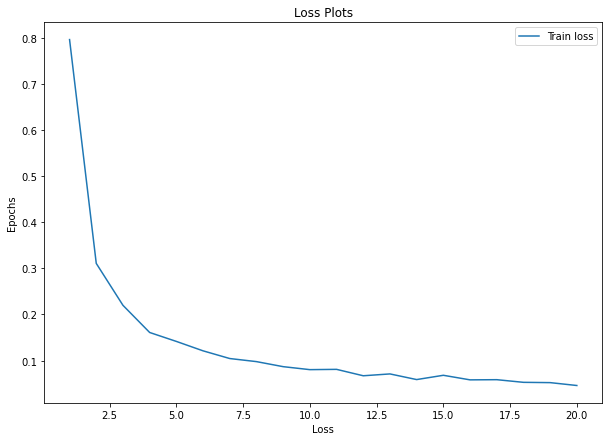

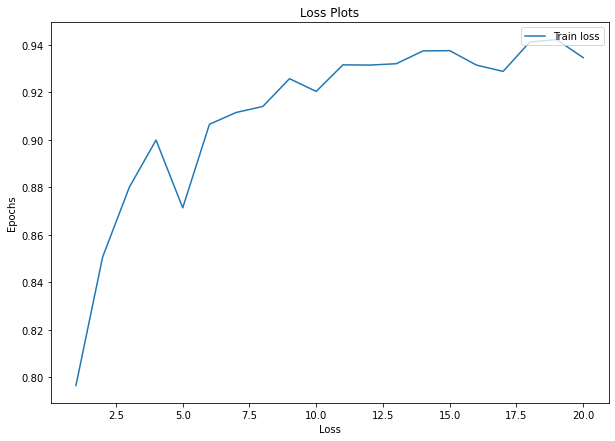

tensor(0.9345, device='cuda:0')

In [16]:
loss_fn = torch.nn.BCELoss()
train(model, loss_fn, train_loader, test_loader)

In [16]:
torch.save(model.state_dict(), "model_weights3.pth") 